# Making summary tables and Cruise Maps

- very preliminary summary information can be taken from select cnv files if NMEA streams are available ()
- more extensive analysis needs to include CTD cast log ingestion into akutan database
    - using the `tools/cruise_config_creater.py` utility (which requires being run on the same machine as the ecofoci database), you can generate the yaml file that will be needed for the plotting to follow
- as the above data will eventually be added to archive netcdf files, one can pull erddap hosted data or nc metadata as well to make the following plots

***most plots will be made using the yaml files generated from the database for these examples***

In [10]:
import yaml
import glob

In [11]:
import EcoFOCIpy.metaconfig.load_config as load_config

In [28]:
sample_data_dir = '/Users/bell/'

In [29]:
###############################################################
# edit to point to {cruise sepcific} yaml database output files
cruise_name = 'DY1307L2' #no hyphens
cruise_meta_file = sample_data_dir+'ecoraid/2013/CTDcasts/DY1307L2/logs/DY1307L2.yaml'
###############################################################


## Ingest Meta (yaml) file and show example of content

In [30]:
#just a dictionary of dictionaries - simple
with open(cruise_meta_file) as file:
    cruise_config = yaml.full_load(file)
cruise_config[cruise_name]

{'CruiseID': 'DY1307L2',
 'CruiseID_Historic': 'DY1307',
 'CruiseID_Alternates': '',
 'Project_Leg': 'L2',
 'Vessel': 'R/V Oscar Dyson',
 'ShipID': 'DY',
 'StartDate': datetime.date(2013, 6, 30),
 'EndDate': datetime.date(2013, 7, 18),
 'Project': 'MACE',
 'ChiefScientist': 'Neal Williamson',
 'StartPort': 'Kodiak, AK',
 'EndPort': 'Kodiak, AK',
 'CruiseLocation': '',
 'Description': 'Gulf of Alaska Acoustic-Trawl Survey of Walleye Pollock, CTD',
 'CruiseYear': 2013,
 'ctdlogs_pdf_name': 'DY1307_CTDLogs.pdf'}

In [32]:
cruise_config['CTDCasts']['CTD017']

{'id': 21690,
 'Vessel': 'R/V Oscar Dyson',
 'CruiseID': 'DY1307',
 'Project_Leg': 'L2',
 'UniqueCruiseID': 'DY1307L2',
 'Project': '',
 'StationNo_altname': '17',
 'ConsecutiveCastNo': 'CTD017',
 'LatitudeDeg': 58,
 'LatitudeMin': 42.33,
 'LongitudeDeg': 152,
 'LongitudeMin': 43.93,
 'GMTDay': 1,
 'GMTMonth': 'Jul',
 'GMTYear': 2013,
 'GMTTime': 39000,
 'DryBulb': -99.9,
 'RelativeHumidity': -999,
 'WetBulb': -99.9,
 'Pressure': 1006,
 'SeaState': '-99',
 'Visibility': '-99',
 'WindDir': 122,
 'WindSpd': 18.0,
 'CloudAmt': '-99',
 'CloudType': '-99',
 'Weather': '-99',
 'SurfaceTemp': -99.9,
 'BottomDepth': 181,
 'StationNameID': 'ME70',
 'MaxDepth': 170,
 'InstrumentSerialNos': 'Press SN = 0772, Pri Temp SN = 2376, Sec Temp SN = 4379, Pri Cond SN = 2985, Sec Cond Sn = 3127, PAR Sn = 70281, Fluor Sn = WETStar 868, pri O2 Sn = 0904, sec O2 Sn = 1961',
 'Notes': '',
 'NutrientBtlNiskinNo': '',
 'NutrientBtlNumbers': '',
 'OxygenBtlNiskinNo': '',
 'OxygenBtlNumbers': '',
 'SalinityBtlNis

## Make Maps

- cartopy (good base map generator, easy to use, easy to install)
- pygmt (better looking maps, GMT language can be hard to understand, not always easy to install as a package)
- holoviz is a dynamic map which is nice but requires more overhead to use
- other dynamic rendered javascript libraries like Altair may be useful
- outputting geojson files allows easy use of geojson.io or leaflet or other tools to make dynamic maps

### Cartopy 

In [33]:
#we need to pull lat/lon/{variable to contour/color if wanted} out of the yaml file
latitude = [cruise_config['CTDCasts'][x]['LatitudeDeg']+cruise_config['CTDCasts'][x]['LatitudeMin']/60 for x in cruise_config['CTDCasts'].keys()]
longitude = [-1* (cruise_config['CTDCasts'][x]['LongitudeDeg']+cruise_config['CTDCasts'][x]['LongitudeMin']/60) for x in cruise_config['CTDCasts'].keys()]

# and setup the plot boundaries given the region
extent=[-180, -150, 52.5, 65] #Bering
# extent=[-160, -144.5, 54, 61] #GOA-West
# extent=[-160, -125.5, 42, 61] #GOA
# extent=[-180, -150, 60, 72] #NBering-Arctic


In [34]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(12,12),
                           subplot_kw=dict(projection=projection))
    if projection == ccrs.PlateCarree():
        gl = ax.gridlines(draw_labels=True)
        gl.xlabels_top = gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
    return fig, ax


In [35]:
#using xarray for bathymetry data read
from erddapy import ERDDAP
import xarray as xa
import cmocean

#you can change the dataset that gets used for bathymetry, this is a very high res one and will take time to load
#  variable names may need to be changed though in following cell
server_url = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/usgsCeSS111'
bathy = xa.open_dataset(server_url) 
bathy_sub = bathy.sel(latitude=slice(extent[3],extent[2]),longitude=slice(extent[0],extent[1]))


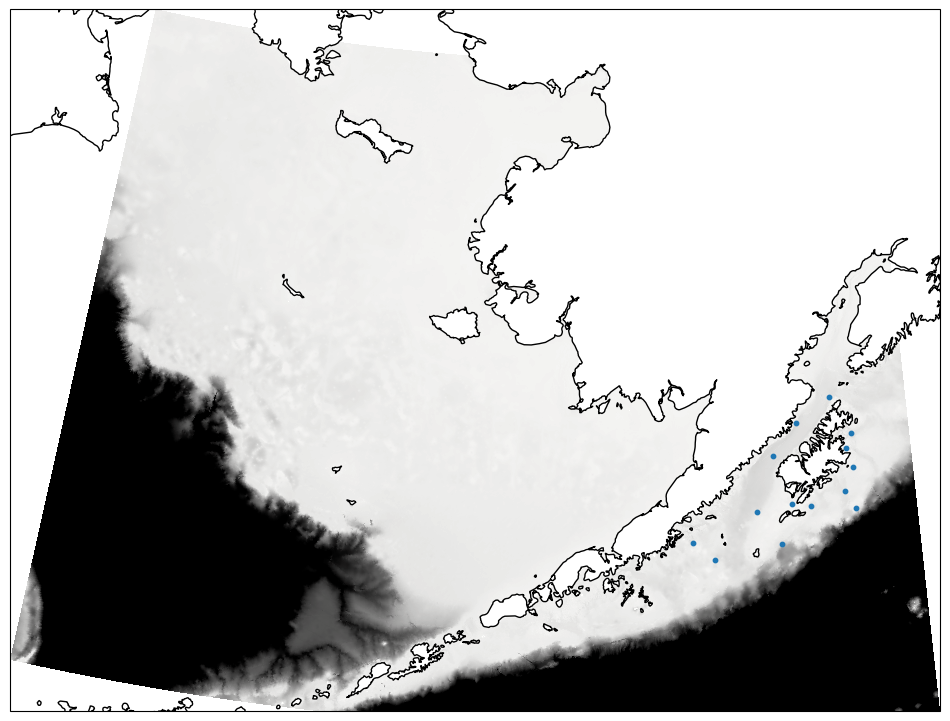

In [36]:
#this is fast if topo is turned off
with_topo = True

projection=ccrs.LambertConformal(central_longitude=-160.0)
transformation=ccrs.PlateCarree()

land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                                edgecolor='face',
                                                facecolor='1.0')

fig,ax = make_map(projection=projection)

if with_topo:
    ax.pcolormesh(bathy_sub.longitude, bathy_sub.latitude, 
                bathy_sub.topo, cmap=cmocean.cm.gray,
                vmin=-3000,vmax=100,
                transform=transformation)
c = ax.scatter(longitude, latitude, s=10,
                               transform=transformation)
#plt.colorbar(c)
ax.add_feature(land_50m)
ax.coastlines(resolution='10m')
ax.set_extent(extent)
        

fig.savefig(f"{cruise_config[cruise_name]['CruiseID']}.png",dpi=300)

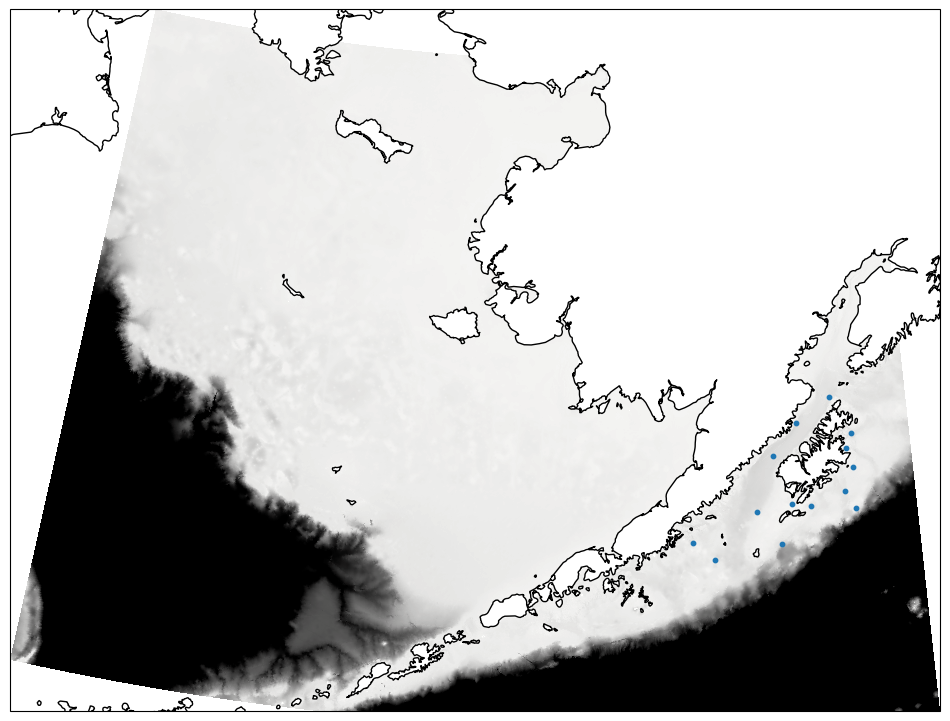

In [37]:
with_topo = True

projection=ccrs.LambertConformal(central_longitude=-160.0)
transformation=ccrs.PlateCarree()

land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                                edgecolor='face',
                                                facecolor='1.0')

fig,ax = make_map(projection=projection)

if with_topo:
    ax.pcolormesh(bathy_sub.longitude, bathy_sub.latitude, 
                bathy_sub.topo, cmap=cmocean.cm.gray,
                vmin=-3000,vmax=100,
                transform=transformation)
c = ax.scatter(longitude, latitude, s=10,
                               transform=transformation)
#plt.colorbar(c)
ax.add_feature(land_50m)
ax.coastlines(resolution='10m')
ax.set_extent(extent)
        

fig.savefig(f"{cruise_config[cruise_name]['CruiseID']}_topo.png",dpi=300)

### Output GeoJSON for dynamic mapping utilities

- leaflet
- geojson.io

In [38]:
    """
    GeoJSON format example:
    {
        "type": "FeatureCollection",
        "features": [
        {
            "type": "Feature",
            "geometry": {
            "type": "Point",
            "coordinates": [102.0, 0.6]
            },
            "properties": {
            "prop0": "value0"
            }
        },
        {
            "type": "Feature",
            "geometry": {
            "type": "LineString",
            "coordinates": [
                [102.0, 0.0], [103.0, 1.0], [104.0, 0.0], [105.0, 1.0]
            ]
            },
            "properties": {
            "prop1": 0.0,
            "prop0": "value0"
            }
        },
        {
            "type": "Feature",
            "geometry": {
            "type": "Polygon",
            "coordinates": [
                [
                [100.0, 0.0], [101.0, 0.0], [101.0, 1.0], [100.0, 1.0],
                [100.0, 0.0]
                ]
            ]
            },
            "properties": {
            "prop1": {
                "this": "that"
            },
            "prop0": "value0"
            }
        }
        ]
    }"""

    geojson_header = "{\n" '"type": "FeatureCollection",\n' '"features": [\n'
    geojson_Features = ""
    for ind, value in enumerate(cruise_config['CTDCasts']):
        geojson_Features = geojson_Features + (
            "{{\n"
            '"type": "Feature",\n'
            '"id": {2},\n'
            '"geometry": {{\n'
            '"type": "Point",\n'
            '"coordinates": '
            "[{1},{0}]"
            "}},\n"
            '"properties": {{\n'
            '"Project": "{3}",'
            '"ConsecutiveCastNo": "{4}",'
            '"StationNameID": "{5}",'
            '"GMTYear": "{6}",'
            '"GMTMonth": "{7}",'
            '"GMTDay": "{8}",'
            '"GMTTime": "{9}"'
            "}}\n"
        ).format(
            cruise_config['CTDCasts'][value]['LatitudeDeg'] + cruise_config['CTDCasts'][value]['LatitudeMin'] / 60,
            -1 * (cruise_config['CTDCasts'][value]['LongitudeDeg'] + cruise_config['CTDCasts'][value]['LongitudeMin'] / 60),
            ind,
            cruise_config['CTDCasts'][value]["Project"],
            cruise_config['CTDCasts'][value]["ConsecutiveCastNo"],
            cruise_config['CTDCasts'][value]["StationNameID"],
            cruise_config['CTDCasts'][value]["GMTYear"],
            cruise_config['CTDCasts'][value]["GMTMonth"],
            cruise_config['CTDCasts'][value]["GMTDay"],
            cruise_config['CTDCasts'][value]["GMTTime"],
        )

        if value is not list(cruise_config['CTDCasts'])[-1]:
            geojson_Features = geojson_Features + "}\n, "

    geojson_tail = "}\n" "]\n" "}\n"

    fid = open(cruise_name + ".geo.json", "w")
    fid.write(geojson_header + geojson_Features + geojson_tail)
    fid.close()


## PYGMT

/var/folders/g1/6qjvrwsx0vb6ltz_4gv0tmxr0000jm/T/ipykernel_15776/954164163.py:27: FutureWarning: The 'color' parameter has been deprecated since v0.8.0 and will be removed in v0.12.0. Please use 'fill' instead.
  fig.plot(x=longitude, y=latitude, style="c0.3c", color="red", pen="black")


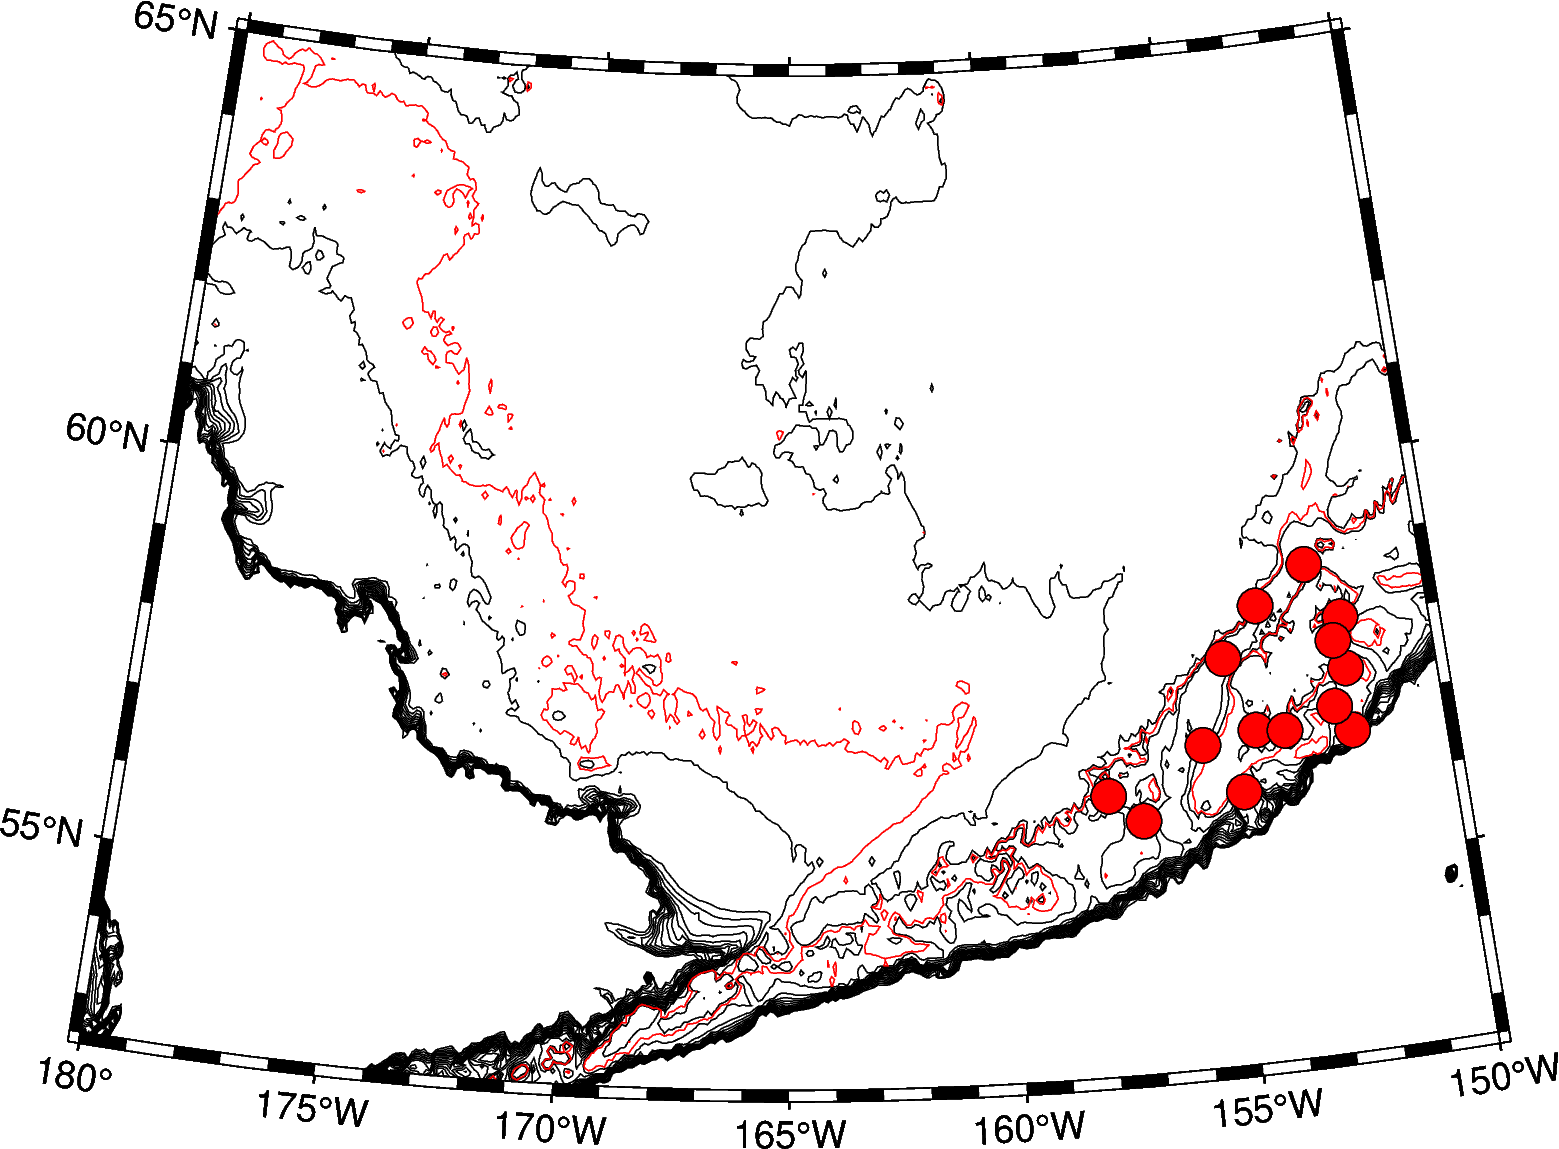

In [39]:
import pygmt

# and setup the plot boundaries given the region
extent=[-180, -150, 52.5, 65] #Bering
# extent=[-160, -144.5, 54, 61] #GOA-West
# extent=[-160, -125.5, 42, 61] #GOA
# extent=[-180, -150, 60, 72] #NBering-Arctic

grid = pygmt.datasets.load_earth_relief(resolution="05m", region=extent) #datasets here can be found in the documentation... many are SRTM derived at high res and will be downloaded to start

fig = pygmt.Figure()
#fixed interval grids with a secondary color for a isobath of interest
# in this case countour 0,100,200...1500 in black and 70m in red and don't label anything
fig.grdcontour(annotation=None,
               interval=100,
               grid=grid,
               limit=[-1500, 0],
               projection="L-165/35/33/45/12c",
               frame=True,)
fig.grdcontour(annotation=None,
               interval=70,
               grid=grid,
               limit=[-100, -1],
               projection="L-165/35/33/45/12c",
               pen="red",
               frame=True,)
fig.plot(x=longitude, y=latitude, style="c0.3c", color="red", pen="black")
fig.show()

fig.savefig(f"{cruise_config[cruise_name]['CruiseID']}_map.png",dpi=300)

### Other Options

- kml/kmz files for google earth